# Naive Bayes of Depression Professional Dataset

### Library Import Session

Bagian untuk mengimpor semua library yang diperlukan untuk pemrosesan data, logika, dan evaluasi.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data Session

Tahap inisialisasi untuk memuat dataset format CSV dari direktori penyimpanan lokal serta menampilkan sampel awal data untuk memastikan struktur terbaca dengan benar.

In [3]:
data = pd.read_csv('../dataset/depression-professional-dataset.csv')

### Exploratory Data Analysis (EDA)

Proses eksplorasi awal untuk memahami karakteristik dataset melalui pengecekan tipe data, statistik deskriptif, dan visualisasi distribusi target kelas guna mendeteksi ketidakseimbangan data.


 INFORMASI DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 2054 non-null   object 
 1   Age                                    2054 non-null   int64  
 2   Work Pressure                          2054 non-null   float64
 3   Job Satisfaction                       2054 non-null   float64
 4   Sleep Duration                         2054 non-null   object 
 5   Dietary Habits                         2054 non-null   object 
 6   Have you ever had suicidal thoughts ?  2054 non-null   object 
 7   Work Hours                             2054 non-null   int64  
 8   Financial Stress                       2054 non-null   int64  
 9   Family History of Mental Illness       2054 non-null   object 
 10  Depression                             2054 non-nul

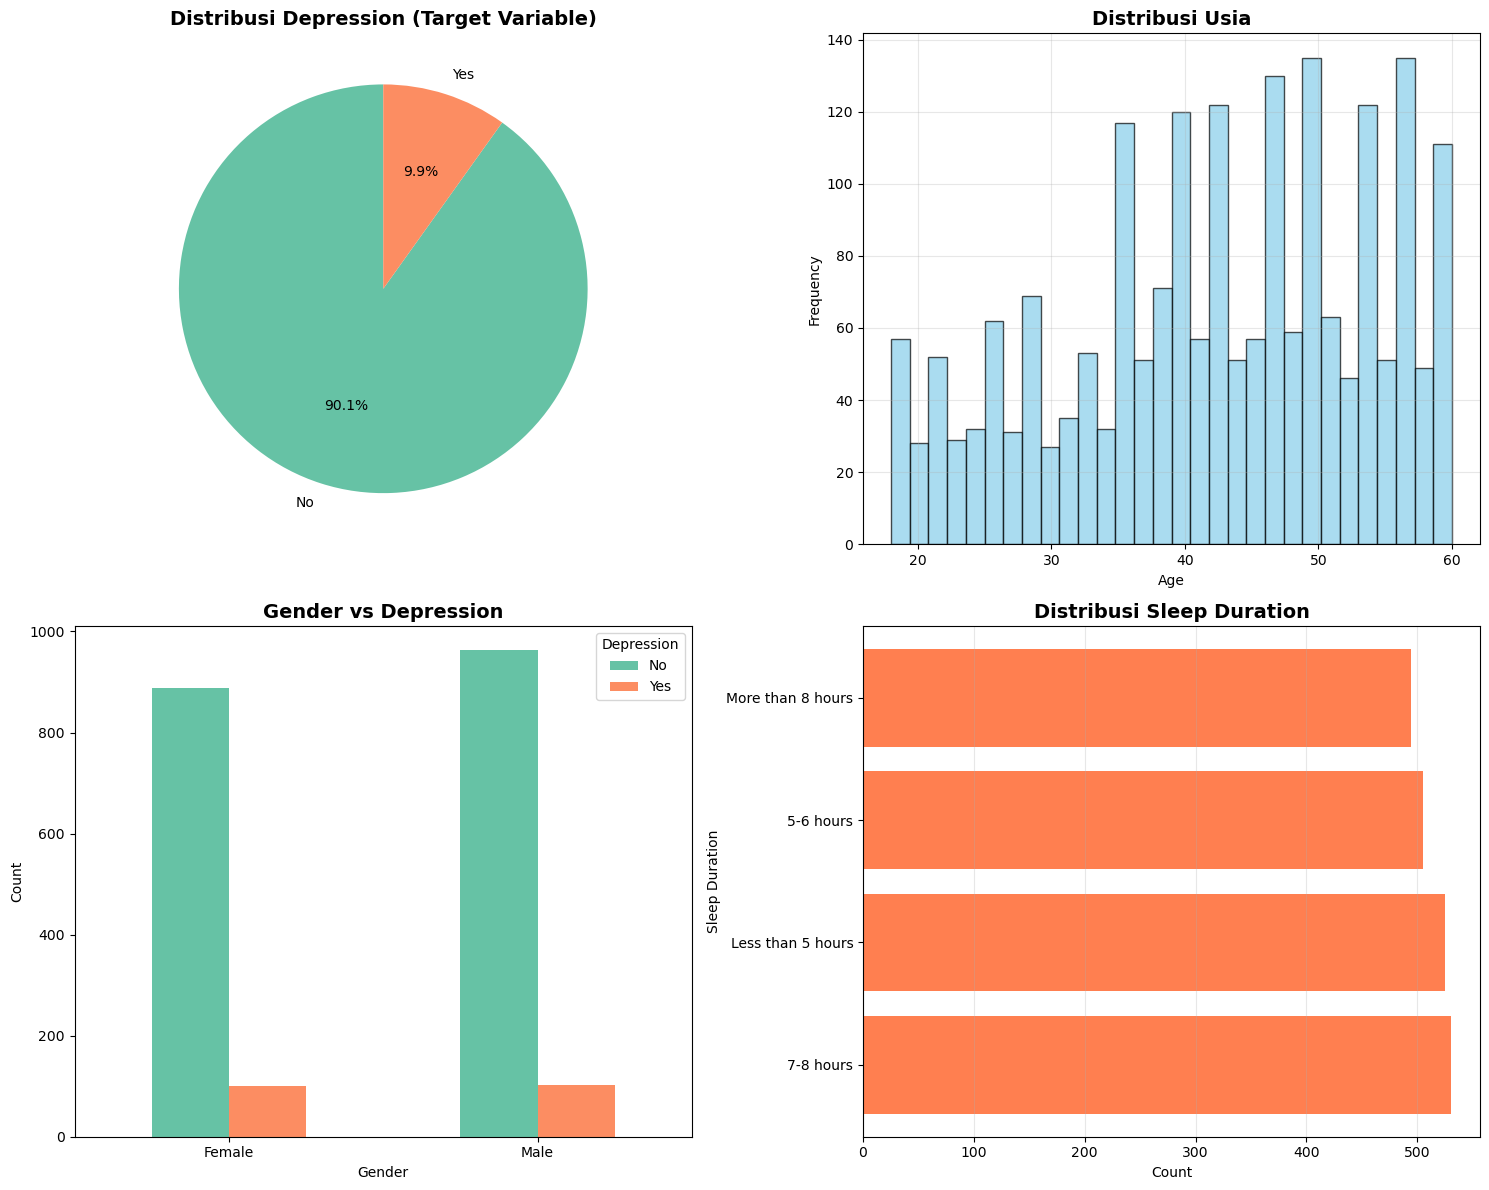

In [6]:
# 1. Load Dataset
print("\n INFORMASI DATASET:")
print(data.info())

# 3.2 Statistik Deskriptif
print("\n STATISTIK DESKRIPTIF:")
print(data.describe())

# 3.3 Cek Missing Values
print("\n CEK MISSING VALUES:")
missing = data.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "✓ Tidak ada missing values!")

# 3.4 Distribusi Target Variable
print("\n DISTRIBUSI TARGET (Depression):")
target_dist = data['Depression'].value_counts()
print(target_dist)
print(f"\nPersentase:")
print(data['Depression'].value_counts(normalize=True) * 100)

# Visualisasi 1: Target Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Target Distribution
axes[0, 0].pie(target_dist.values, labels=target_dist.index, autopct='%1.1f%%', 
               colors=['#66c2a5', '#fc8d62'], startangle=90)
axes[0, 0].set_title('Distribusi Depression (Target Variable)', fontsize=14, fontweight='bold')

# Plot 2: Age Distribution
axes[0, 1].hist(data['Age'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribusi Usia', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Gender vs Depression
gender_dep = pd.crosstab(data['Gender'], data['Depression'])
gender_dep.plot(kind='bar', ax=axes[1, 0], color=['#66c2a5', '#fc8d62'])
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Gender vs Depression', fontsize=14, fontweight='bold')
axes[1, 0].legend(title='Depression')
axes[1, 0].tick_params(axis='x', rotation=0)

# Plot 4: Sleep Duration Distribution
sleep_counts = data['Sleep Duration'].value_counts()
axes[1, 1].barh(sleep_counts.index, sleep_counts.values, color='coral')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Sleep Duration')
axes[1, 1].set_title('Distribusi Sleep Duration', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../images/naive-bayes/01_EDA_Overview.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualisasi EDA disimpan: ../images/naive-bayes/01_EDA_Overview.png")
plt.show()

### Data Preprocessing

Tahap persiapan data yang mencakup konversi variabel kategorikal menjadi numerik (Encoding) dan penyeragaman skala data (Standard Scaling) agar optimal saat diproses oleh algoritma.

  1. Gender_Encoded
  2. Age
  3. Work Pressure
  4. Job Satisfaction
  5. Sleep_Duration_Numeric
  6. Dietary_Encoded
  7. Suicidal_Encoded
  8. Work Hours
  9. Financial Stress
  10. FamilyHistory_Encoded

Shape X: (2054, 10)
Shape y: (2054,)


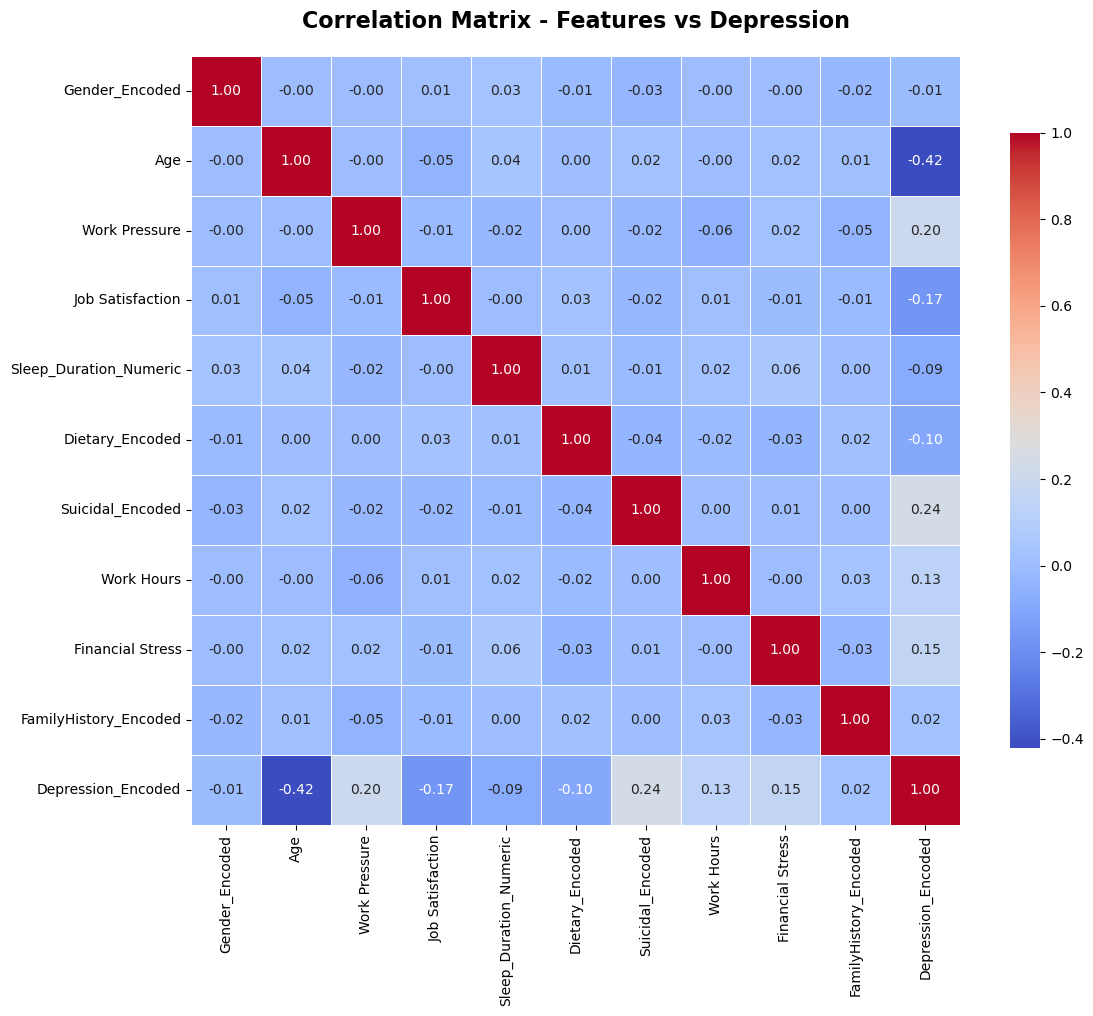

In [7]:
# Salin dataset
data_copy = data.copy()

# Hapus Duplikasi
data_copy.drop_duplicates(inplace=True)

# Hapus Empty Data
data_copy.replace('', np.nan, inplace=True)

# Special Processing for Sleep Duration
def convert_sleep_duration(duration):
    if 'Less than 5' in duration:
        return 4.0
    elif '5-6' in duration:
        return 5.5
    elif '7-8' in duration:
        return 7.5
    elif 'More than 8' in duration:
        return 9.0
    else:
        return 7.0  # default value

data_copy['Sleep_Duration_Numeric'] = data_copy['Sleep Duration'].apply(convert_sleep_duration)

# Binary Gender Labeling (Male = 1, Female = 0)
data_copy['Gender_Encoded'] = (data_copy['Gender'] == 'Male').astype(int)

# Binary Dietary Habits Labeling (Healthy = 2, Moderate = 1, Unhealthy = 0)
dietary_map = {'Healthy': 2, 'Moderate': 1, 'Unhealthy': 0}
data_copy['Dietary_Encoded'] = data_copy['Dietary Habits'].map(dietary_map)

# Binary Suicidal Thoughts Labeling (Suicidal = 1, Not Suicidal = 0)
data_copy['Suicidal_Encoded'] = (data_copy['Have you ever had suicidal thoughts ?'] == 'Yes').astype(int)

# Binary Mental Ilness Labeling (Family History: Yes = 1, No = 0)
data_copy['FamilyHistory_Encoded'] = (data_copy['Family History of Mental Illness'] == 'Yes').astype(int)

# Binary Depression Labeling (Depression: Yes = 1, No = 0)
data_copy['Depression_Encoded'] = (data_copy['Depression'] == 'Yes').astype(int)

# Select features for correlation analysis
features_for_model = [
    'Gender_Encoded',
    'Age',
    'Work Pressure',
    'Job Satisfaction',
    'Sleep_Duration_Numeric',
    'Dietary_Encoded',
    'Suicidal_Encoded',
    'Work Hours',
    'Financial Stress',
    'FamilyHistory_Encoded'
]

X = data_copy[features_for_model].values
y = data_copy['Depression_Encoded'].values

for i, feat in enumerate(features_for_model, 1):
    print(f"  {i}. {feat}")
print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")

# Correlation Matrix
correlation_data = data_copy[features_for_model + ['Depression_Encoded']]
corr_matrix = correlation_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Features vs Depression', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../images/naive-bayes/02_Correlation_Matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Data Splitting

Mekanisme pembagian dataset menjadi dua bagian terpisah, yaitu data training untuk melatih model dan data testing untuk validasi objektif, dengan rasio pembagian yang telah ditentukan.

In [8]:

def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X)
    indices = np.random.permutation(n_samples)
    
    train_size = int(train_ratio * n_samples)
    val_size = int(val_ratio * n_samples)
    
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size + val_size]
    test_idx = indices[train_size + val_size:]
    
    return (X[train_idx], X[val_idx], X[test_idx],
            y[train_idx], y[val_idx], y[test_idx])

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

print(f"  Training set   : {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation set : {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test set       : {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n  Distribusi Target di Training Set:")
print(f"    - Depression=No  : {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"    - Depression=Yes : {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")


  Training set   : 1437 samples (70.0%)
  Validation set : 308 samples (15.0%)
  Test set       : 309 samples (15.0%)

  Distribusi Target di Training Set:
    - Depression=No  : 1293 (90.0%)
    - Depression=Yes : 144 (10.0%)


### Naive Bayes Implementation

Implementasi algoritma Naive Bayes, disertai eksperimen pencarian parameter terbaik untuk mendapatkan performa model yang maksimal.

In [9]:
class GaussianNaiveBayes:
    """
    Implementasi Gaussian Naive Bayes dari nol
    
    Formula:
    P(y|X) ∝ P(y) * ∏ P(xi|y)
    
    Dimana:
    - P(y) = prior probability
    - P(xi|y) = likelihood (menggunakan Gaussian distribution)
    """
    
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing
        self.classes = None
        self.priors = {}
        self.means = {}
        self.variances = {}
        
    def fit(self, X, y):
        """
        Training Naive Bayes model
        """
        self.classes = np.unique(y)
        n_samples = len(y)
        
        for c in self.classes:
            # Data untuk class c
            X_c = X[y == c]
            
            # Hitung Prior: P(y=c)
            self.priors[c] = len(X_c) / n_samples
            
            # Hitung Mean dan Variance untuk setiap feature
            self.means[c] = np.mean(X_c, axis=0)
            self.variances[c] = np.var(X_c, axis=0) + self.var_smoothing
        
        return self
    
    def _calculate_likelihood(self, x, mean, variance):
        """
        Hitung likelihood menggunakan Gaussian PDF
        P(x|y) = (1/√(2πσ²)) * exp(-(x-μ)²/(2σ²))
        """
        eps = 1e-10  # untuk menghindari division by zero
        exponent = -((x - mean) ** 2) / (2 * variance + eps)
        coefficient = 1 / np.sqrt(2 * np.pi * variance + eps)
        return coefficient * np.exp(exponent)
    
    def _calculate_posterior(self, x):
        """
        Hitung posterior probability untuk setiap class
        P(y|X) ∝ P(y) * ∏ P(xi|y)
        
        Menggunakan log untuk stabilitas numerik:
        log P(y|X) = log P(y) + Σ log P(xi|y)
        """
        posteriors = {}
        
        for c in self.classes:
            # Log prior
            posterior = np.log(self.priors[c])
            
            # Log likelihood untuk setiap feature
            for i in range(len(x)):
                likelihood = self._calculate_likelihood(
                    x[i], 
                    self.means[c][i], 
                    self.variances[c][i]
                )
                posterior += np.log(likelihood + 1e-10)  # tambah epsilon untuk avoid log(0)
            
            posteriors[c] = posterior
        
        return posteriors
    
    def predict(self, X):
        """
        Prediksi class untuk setiap sample
        """
        predictions = []
        
        for x in X:
            posteriors = self._calculate_posterior(x)
            # Pilih class dengan posterior tertinggi
            predicted_class = max(posteriors, key=posteriors.get)
            predictions.append(predicted_class)
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        """
        Prediksi probability untuk setiap class
        """
        probas = []
        
        for x in X:
            posteriors = self._calculate_posterior(x)
            
            # Konversi log probability ke probability
            # Menggunakan softmax untuk normalisasi
            log_probs = np.array([posteriors[c] for c in self.classes])
            max_log_prob = np.max(log_probs)
            exp_probs = np.exp(log_probs - max_log_prob)
            probs = exp_probs / np.sum(exp_probs)
            
            probas.append(probs)
        
        return np.array(probas)

### Training Model

In [10]:
# Inisialisasi dan training model
nb_model = GaussianNaiveBayes(var_smoothing=1e-9)
nb_model.fit(X_train, y_train)

print("✓ Model berhasil ditraining!")

# Tampilkan parameter yang dipelajari
print("\n PARAMETER MODEL:")
print("\n1. PRIOR PROBABILITIES:")
for c in nb_model.classes:
    print(f"   P(Depression={['No', 'Yes'][c]}) = {nb_model.priors[c]:.4f}")

print("\n2. MEAN VALUES PER FEATURE (Class 0 - No Depression):")
for i, feat in enumerate(features_for_model):
    print(f"   {feat}: {nb_model.means[0][i]:.4f}")

print("\n3. MEAN VALUES PER FEATURE (Class 1 - Depression):")
for i, feat in enumerate(features_for_model):
    print(f"   {feat}: {nb_model.means[1][i]:.4f}")

✓ Model berhasil ditraining!

 PARAMETER MODEL:

1. PRIOR PROBABILITIES:
   P(Depression=No) = 0.8998
   P(Depression=Yes) = 0.1002

2. MEAN VALUES PER FEATURE (Class 0 - No Depression):
   Gender_Encoded: 0.5220
   Age: 43.7773
   Work Pressure: 2.9474
   Job Satisfaction: 3.1005
   Sleep_Duration_Numeric: 6.5735
   Dietary_Encoded: 0.9969
   Suicidal_Encoded: 0.4346
   Work Hours: 5.7734
   Financial Stress: 2.8964
   FamilyHistory_Encoded: 0.4826

3. MEAN VALUES PER FEATURE (Class 1 - Depression):
   Gender_Encoded: 0.5000
   Age: 27.5000
   Work Pressure: 3.8750
   Job Satisfaction: 2.3611
   Sleep_Duration_Numeric: 5.8993
   Dietary_Encoded: 0.7222
   Suicidal_Encoded: 0.8403
   Work Hours: 7.4375
   Financial Stress: 3.5417
   FamilyHistory_Encoded: 0.5000


### Hyperparameter Turing



  var_smoothing=1e-10 → Validation Accuracy: 97.08%
  var_smoothing=1e-09 → Validation Accuracy: 97.08%
  var_smoothing=1e-08 → Validation Accuracy: 97.08%
  var_smoothing=1e-07 → Validation Accuracy: 97.08%
  var_smoothing=1e-06 → Validation Accuracy: 97.08%
  var_smoothing=1e-05 → Validation Accuracy: 97.08%
  var_smoothing=1e-04 → Validation Accuracy: 97.08%

✓ BEST HYPERPARAMETER:
  var_smoothing = 1e-10
  Validation Accuracy = 97.08%

✓ Grafik hyperparameter tuning disimpan: ../images/naive-bayes/03_Hyperparameter_Tuning.png


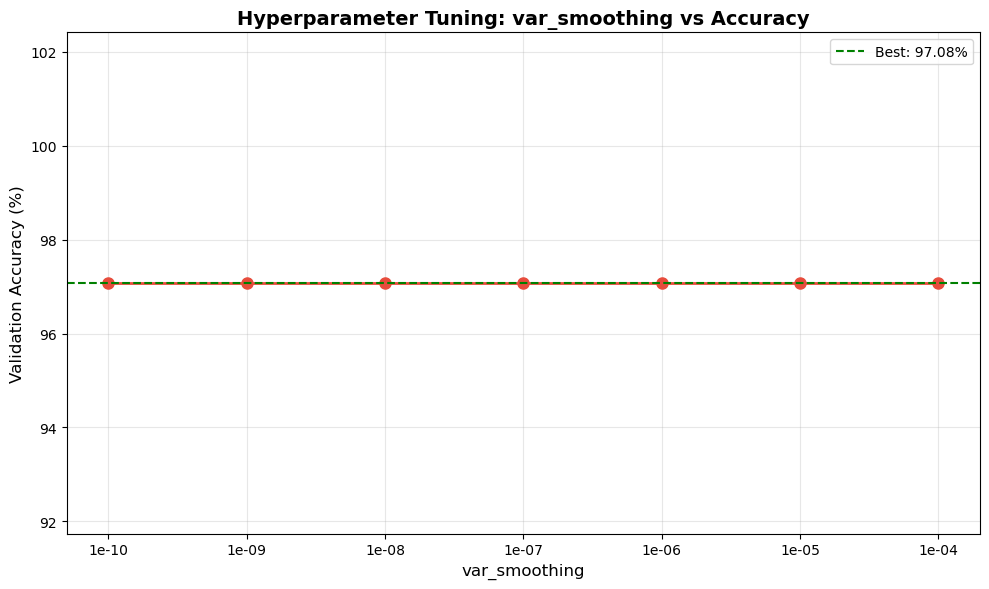


 RETRAINING MODEL DENGAN BEST HYPERPARAMETER...
✓ Final model berhasil ditraining!


In [11]:
# Nilai var_smoothing yang akan dicoba
smoothing_values = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

results = []

for smoothing in smoothing_values:
    # Training dengan smoothing parameter berbeda
    model = GaussianNaiveBayes(var_smoothing=smoothing)
    model.fit(X_train, y_train)
    
    # Prediksi pada validation set
    y_val_pred = model.predict(X_val)
    
    # Hitung accuracy
    accuracy = np.mean(y_val_pred == y_val)
    
    results.append({
        'smoothing': smoothing,
        'accuracy': accuracy
    })
    
    print(f"  var_smoothing={smoothing:.0e} → Validation Accuracy: {accuracy*100:.2f}%")

# Pilih smoothing terbaik
best_result = max(results, key=lambda x: x['accuracy'])
best_smoothing = best_result['smoothing']
best_accuracy = best_result['accuracy']

print(f"\n✓ BEST HYPERPARAMETER:")
print(f"  var_smoothing = {best_smoothing:.0e}")
print(f"  Validation Accuracy = {best_accuracy*100:.2f}%")

# Visualisasi Hyperparameter Tuning
plt.figure(figsize=(10, 6))
smoothing_labels = [f"{s:.0e}" for s in smoothing_values]
accuracies = [r['accuracy'] * 100 for r in results]

plt.plot(smoothing_labels, accuracies, marker='o', linewidth=2, markersize=8, color='#e74c3c')
plt.axhline(y=best_accuracy*100, color='green', linestyle='--', label=f'Best: {best_accuracy*100:.2f}%')
plt.xlabel('var_smoothing', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.title('Hyperparameter Tuning: var_smoothing vs Accuracy', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('../images/naive-bayes/03_Hyperparameter_Tuning.png', dpi=300, bbox_inches='tight')
print("\n✓ Grafik hyperparameter tuning disimpan: ../images/naive-bayes/03_Hyperparameter_Tuning.png")
plt.show()

# Retrain dengan best parameter
print(f"\n RETRAINING MODEL DENGAN BEST HYPERPARAMETER...")
final_model = GaussianNaiveBayes(var_smoothing=best_smoothing)
final_model.fit(X_train, y_train)
print("✓ Final model berhasil ditraining!")


### Model Evaluation

Tahap pengukuran kinerja model menggunakan metrik evaluasi standar seperti Akurasi, Presisi, Recall, F1-Score, serta visualisasi Confusion Matrix untuk menganalisis kesalahan prediksi.


 HASIL EVALUASI MODEL:

TRAINING SET:
  Accuracy  : 94.92%
  Precision : 100.00%
  Recall    : 49.31%
  F1-Score  : 66.05%

VALIDATION SET:
  Accuracy  : 97.08%
  Precision : 100.00%
  Recall    : 65.38%
  F1-Score  : 79.07%

TEST SET (FINAL PERFORMANCE):
  Accuracy  : 95.15%
  Precision : 100.00%
  Recall    : 54.55%
  F1-Score  : 70.59%

✓ Visualisasi evaluasi disimpan: ../images/naive-bayes/04_Model_Evaluation.png


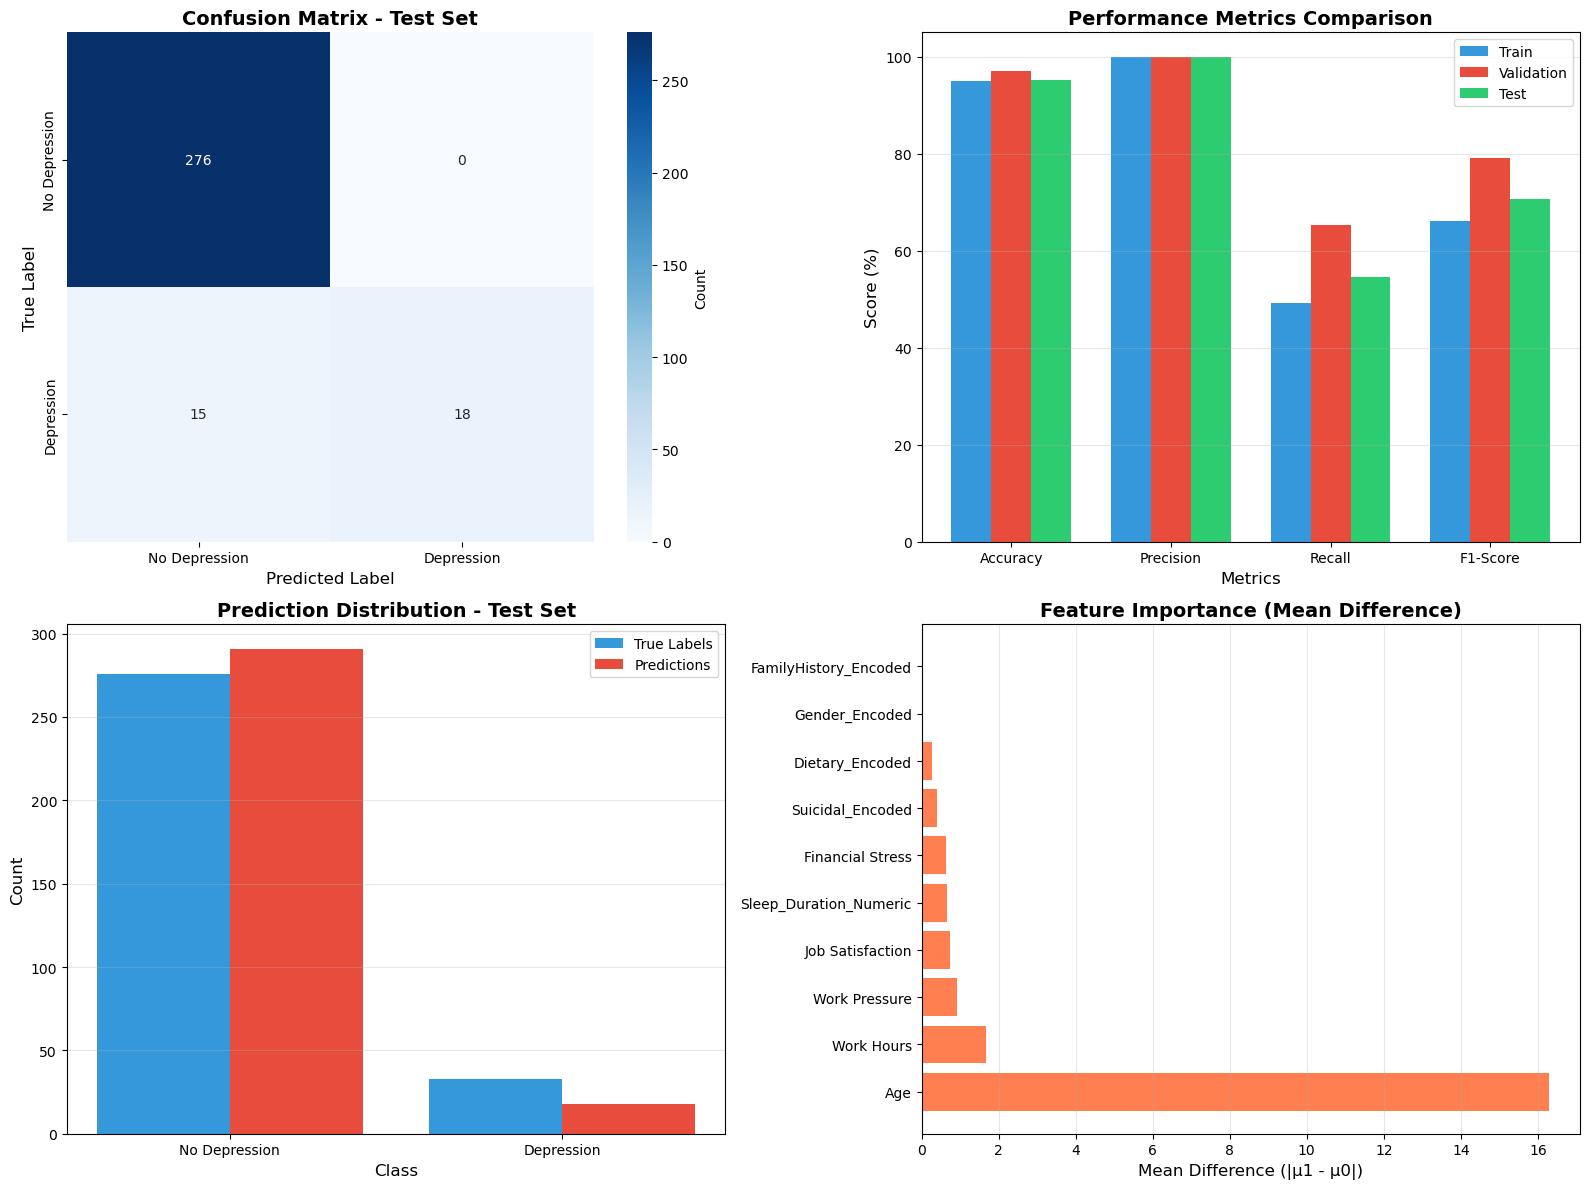

In [12]:
def calculate_metrics(y_true, y_pred):
    """
    Hitung metrics: accuracy, precision, recall, f1-score
    """
    # True Positives, False Positives, True Negatives, False Negatives
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': np.array([[tn, fp], [fn, tp]])
    }

# Prediksi pada semua set
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)
y_test_pred = final_model.predict(X_test)

# Hitung metrics
train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# Tampilkan hasil
print("\n HASIL EVALUASI MODEL:")
print("\n" + "="*60)
print("TRAINING SET:")
print("="*60)
print(f"  Accuracy  : {train_metrics['accuracy']*100:.2f}%")
print(f"  Precision : {train_metrics['precision']*100:.2f}%")
print(f"  Recall    : {train_metrics['recall']*100:.2f}%")
print(f"  F1-Score  : {train_metrics['f1_score']*100:.2f}%")

print("\n" + "="*60)
print("VALIDATION SET:")
print("="*60)
print(f"  Accuracy  : {val_metrics['accuracy']*100:.2f}%")
print(f"  Precision : {val_metrics['precision']*100:.2f}%")
print(f"  Recall    : {val_metrics['recall']*100:.2f}%")
print(f"  F1-Score  : {val_metrics['f1_score']*100:.2f}%")

print("\n" + "="*60)
print("TEST SET (FINAL PERFORMANCE):")
print("="*60)
print(f"  Accuracy  : {test_metrics['accuracy']*100:.2f}%")
print(f"  Precision : {test_metrics['precision']*100:.2f}%")
print(f"  Recall    : {test_metrics['recall']*100:.2f}%")
print(f"  F1-Score  : {test_metrics['f1_score']*100:.2f}%")

# Visualisasi Results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Confusion Matrix - Test Set
cm = test_metrics['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'],
            cbar_kws={'label': 'Count'})
axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
axes[0, 0].set_ylabel('True Label', fontsize=12)
axes[0, 0].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')

# Plot 2: Metrics Comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_metrics['accuracy'], train_metrics['precision'], 
                train_metrics['recall'], train_metrics['f1_score']]
val_scores = [val_metrics['accuracy'], val_metrics['precision'], 
              val_metrics['recall'], val_metrics['f1_score']]
test_scores = [test_metrics['accuracy'], test_metrics['precision'], 
               test_metrics['recall'], test_metrics['f1_score']]

x = np.arange(len(metrics_names))
width = 0.25

axes[0, 1].bar(x - width, [s*100 for s in train_scores], width, label='Train', color='#3498db')
axes[0, 1].bar(x, [s*100 for s in val_scores], width, label='Validation', color='#e74c3c')
axes[0, 1].bar(x + width, [s*100 for s in test_scores], width, label='Test', color='#2ecc71')

axes[0, 1].set_xlabel('Metrics', fontsize=12)
axes[0, 1].set_ylabel('Score (%)', fontsize=12)
axes[0, 1].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_names)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_ylim([0, 105])

# Plot 3: Prediction Distribution - Test Set
pred_counts = pd.Series(y_test_pred).value_counts().sort_index()
true_counts = pd.Series(y_test).value_counts().sort_index()

x_pos = np.arange(2)
axes[1, 0].bar(x_pos - 0.2, true_counts.values, 0.4, label='True Labels', color='#3498db')
axes[1, 0].bar(x_pos + 0.2, pred_counts.values, 0.4, label='Predictions', color='#e74c3c')
axes[1, 0].set_xlabel('Class', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)
axes[1, 0].set_title('Prediction Distribution - Test Set', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(['No Depression', 'Depression'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Feature Importance (berdasarkan mean difference)
feature_importance = []
for i, feat in enumerate(features_for_model):
    diff = abs(final_model.means[1][i] - final_model.means[0][i])
    feature_importance.append((feat, diff))

feature_importance.sort(key=lambda x: x[1], reverse=True)
feat_names = [f[0] for f in feature_importance]
feat_scores = [f[1] for f in feature_importance]

axes[1, 1].barh(feat_names, feat_scores, color='coral')
axes[1, 1].set_xlabel('Mean Difference (|μ1 - μ0|)', fontsize=12)
axes[1, 1].set_title('Feature Importance (Mean Difference)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../images/naive-bayes/04_Model_Evaluation.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualisasi evaluasi disimpan: ../images/naive-bayes/04_Model_Evaluation.png")
plt.show()

### Kesimpulan

In [13]:
print(f"""
   - Accuracy  : {test_metrics['accuracy']*100:.2f}%
   - Precision : {test_metrics['precision']*100:.2f}%
   - Recall    : {test_metrics['recall']*100:.2f}%
   - F1-Score  : {test_metrics['f1_score']*100:.2f}%
""")


   - Accuracy  : 95.15%
   - Precision : 100.00%
   - Recall    : 54.55%
   - F1-Score  : 70.59%

